In [1]:
# %pip install git+https://github.com/rwalk/gsdmm.git

In [1]:
# %pip install yake

In [1]:
import snscrape.modules.twitter as sntwitter
import pandas as pd
import csv
import numpy as np

import contractions
import nltk
from nltk.text import Text
from nltk.corpus import PlaintextCorpusReader
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
stopwords.extend(["&amp", "amp"])

import re

In [2]:
df = pd.read_csv('sg_circuit.csv')

In [3]:
df

,url,date,rawContent,renderedContent,id,user,replyCount,retweetCount,likeCount,quoteCount,...,inReplyToTweetId,inReplyToUser,mentionedUsers,coordinates,place,hashtags,cashtags,card,viewCount,vibe
0,https://twitter.com/yihyng/status/126723739088...,2020-05-31 23:31:52+00:00,call call day,call call day,1267237390881402881,https://twitter.com/yihyng,0,0,1,0,...,NaN,NaN,NaN,"Coordinates(longitude=103.817832999913, latitu...","Place(id='5f1f473ed6455f55', fullName='North-E...",['covid_19'],NaN,NaN,NaN,NaN
1,https://twitter.com/JuiceTales/status/12672317...,2020-05-31 23:09:36+00:00,enter new phase one period healthy body grab n...,enter new phase one period healthy body grab n...,1267231786632790016,https://twitter.com/JuiceTales,0,0,0,0,...,NaN,NaN,NaN,"Coordinates(longitude=103.90126705, latitude=1...","Place(id='58a4c3a0d54e1400', fullName='Central...",NaN,NaN,NaN,NaN,NaN
2,https://twitter.com/sitimariamah1/status/12672...,2020-05-31 22:45:29+00:00,every new month brings new hope new dream new ...,every new month brings new hope new dream new ...,1267225719047950344,https://twitter.com/sitimariamah1,0,0,1,0,...,NaN,NaN,NaN,"Coordinates(longitude=103.93690062, latitude=1...","Place(id='6635b2fcebd13c64', fullName='East Re...",NaN,NaN,NaN,NaN,NaN
3,https://twitter.com/SajidTweetsBD/status/12671...,2020-05-31 15:23:06+00:00,meanwhile new zealand nine day new covid case ...,meanwhile new zealand nine day new covid case ...,1267114389150134272,https://twitter.com/SajidTweetsBD,0,0,0,0,...,NaN,NaN,NaN,"Coordinates(longitude=103.696411999967, latitu...","Place(id='14d9532bd696d8cb', fullName='North R...",NaN,NaN,NaN,NaN,NaN
4,https://twitter.com/audreytan/status/126710979...,2020-05-31 15:04:52+00:00,pandemic unlocked new thing never thought woul...,pandemic unlocked new thing never thought woul...,1267109798010478593,https://twitter.com/audreytan,0,0,1,0,...,NaN,NaN,NaN,"Coordinates(longitude=103.856, latitude=1.29306)","Place(id='58a4c3a0d54e1400', fullName='Central...",['Covid'],NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1799,https://twitter.com/Godliketrader/status/12452...,2020-04-01 04:46:56+00:00,treated humanity cure coronavirusindia coronav...,treated humanity cure coronavirusindia coronav...,1245211019913248770,https://twitter.com/Godliketrader,0,0,0,0,...,NaN,NaN,NaN,"Coordinates(longitude=103.749959507073, latitu...","Place(id='58a4c3a0d54e1400', fullName='Central...","['COVID19', 'coronavirusindia', 'coronavirus']",NaN,NaN,NaN,NaN
1800,https://twitter.com/paepaesays/status/12451946...,2020-04-01 03:42:04+00:00,coronavirus content created singapore awarene...,coronavirus content created singapore awarenes...,1245194696319578113,https://twitter.com/paepaesays,0,0,0,0,...,NaN,NaN,NaN,"Coordinates(longitude=103.605441448115, latitu...","Place(id='0b37664066a8962a', fullName='West Re...","['coronavirus', 'Singapore', 'COVIDー19', 'awar...",NaN,NaN,NaN,NaN
1801,https://twitter.com/_rodahidup/status/12451895...,2020-04-01 03:21:48+00:00,coronavirus employer singapore must allow staf...,coronavirus employer singapore must allow staf...,1245189593411940352,https://twitter.com/_rodahidup,0,0,0,0,...,NaN,NaN,NaN,"Coordinates(longitude=103.605441448115, latitu...","Place(id='0b37664066a8962a', fullName='West Re...",NaN,NaN,NaN,NaN,NaN
1802,https://twitter.com/_rodahidup/status/12451895...,2020-04-01 03:21:30+00:00,coronavirus employer singapore must allow staf...,coronavirus employer singapore must allow staf...,1245189517931249664,https://twitter.com/_rodahidup,0,0,0,0,...,NaN,NaN,NaN,"Coordinates(longitude=103.605441448115, latitu...","Place(id='0b37664066a8962a', fullName='West Re...",NaN,NaN,NaN,NaN,NaN


In [4]:
df.isna().sum()

url                    0
date                   0
rawContent             0
renderedContent        0
id                     0
user                   0
replyCount             0
retweetCount           0
likeCount              0
quoteCount             0
conversationId         0
lang                   0
source                 0
sourceUrl              0
sourceLabel            0
links                951
media               1517
retweetedTweet      1804
quotedTweet         1661
inReplyToTweetId    1615
inReplyToUser       1615
mentionedUsers      1391
coordinates            0
place                  0
hashtags            1119
cashtags            1804
card                1505
viewCount           1804
vibe                1804
dtype: int64

In [3]:
df['rawContent'].fillna('', inplace=True)
df['renderedContent'].fillna('', inplace=True)

In [4]:
## remove specific word HTTP
df['rawContent'] = df['rawContent'].str.replace('covid', '')
df['rawContent'] = df['rawContent'].str.replace('coronavirus', '')

df['renderedContent'] = df['renderedContent'].str.replace('covid', '')
df['renderedContent'] = df['renderedContent'].str.replace('coronavirus', '')

In [5]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (10, 10))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 10)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()

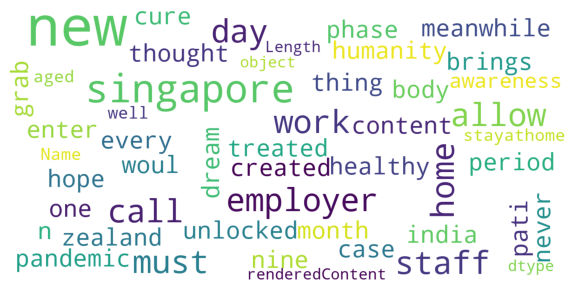

In [8]:
show_wordcloud(df["renderedContent"])

In [6]:
import gensim
from gensim.utils import simple_preprocess

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [7]:
data = df['renderedContent'].values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1][0][:30])

['call', 'call', 'day']


## Building Bi-gram and Tri-gram Models

In [8]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [9]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [13]:
data_words_bigrams = make_bigrams(data_words)
data_words_bigrams

[['call', 'call', 'day'],
 ['enter',
  'new',
  'phase',
  'one',
  'period',
  'healthy',
  'body',
  'grab',
  'new',
  'promo',
  'juice',
  'set',
  'juice',
  'boost',
  'immunity',
  'contains',
  'balance',
  'fruit',
  'vege',
  'free',
  'delivery'],
 ['every',
  'new',
  'month',
  'brings',
  'new',
  'hope',
  'new',
  'dream',
  'new',
  'wish',
  'amp',
  'paryers',
  'wishing',
  'whole',
  'wide',
  'world',
  'free',
  'virus',
  'amp',
  'vaccine',
  'found',
  'soon',
  'possible'],
 ['meanwhile',
  'new',
  'zealand',
  'nine',
  'day',
  'new',
  'case',
  'patient',
  'hospital',
  'one',
  'active',
  'case',
  'remaining',
  'testing',
  'center',
  'closing',
  'plan',
  'underway',
  'open',
  'travel',
  'epidemiologist',
  'say',
  'nz',
  'chance',
  'eliminating',
  'disease',
  'nz',
  'govt'],
 ['pandemic',
  'unlocked',
  'new',
  'thing',
  'never',
  'thought',
  'would',
  'instance',
  'told',
  'often',
  'geraldtock',
  'green',
  'finger',
  'cac

In [10]:
data_words_trigrams = make_trigrams(data_words)
data_words_trigrams

[['call', 'call', 'day'],
 ['enter',
  'new',
  'phase',
  'one',
  'period',
  'healthy',
  'body',
  'grab',
  'new',
  'promo',
  'juice',
  'set',
  'juice',
  'boost',
  'immunity',
  'contains',
  'balance',
  'fruit',
  'vege',
  'free',
  'delivery'],
 ['every',
  'new',
  'month',
  'brings',
  'new',
  'hope',
  'new',
  'dream',
  'new',
  'wish',
  'amp',
  'paryers',
  'wishing',
  'whole',
  'wide',
  'world',
  'free',
  'virus',
  'amp',
  'vaccine',
  'found',
  'soon',
  'possible'],
 ['meanwhile',
  'new',
  'zealand',
  'nine',
  'day',
  'new',
  'case',
  'patient',
  'hospital',
  'one',
  'active',
  'case',
  'remaining',
  'testing',
  'center',
  'closing',
  'plan',
  'underway',
  'open',
  'travel',
  'epidemiologist',
  'say',
  'nz',
  'chance',
  'eliminating',
  'disease',
  'nz',
  'govt'],
 ['pandemic',
  'unlocked',
  'new',
  'thing',
  'never',
  'thought',
  'would',
  'instance',
  'told',
  'often',
  'geraldtock',
  'green',
  'finger',
  'cac

## Building rough LDA model 

In [11]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(data_words_trigrams)

# Create Corpus
texts = data_words_trigrams

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])

[(0, 2), (1, 1)]


In [16]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=5, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [17]:
from pprint import pprint

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.009*"like" + 0.008*"want" + 0.006*"people" + 0.006*"singapore" + '
  '0.006*"news" + 0.005*"one" + 0.005*"go" + 0.005*"take" + 0.005*"keep" + '
  '0.005*"month"'),
 (1,
  '0.041*"singapore" + 0.012*"new" + 0.012*"case" + 0.007*"day" + 0.006*"home" '
  '+ 0.006*"total" + 0.005*"circuitbreaker" + 0.005*"today" + 0.005*"death" + '
  '0.004*"infection"'),
 (2,
  '0.010*"singapore" + 0.009*"time" + 0.009*"home" + 0.007*"stayhome" + '
  '0.006*"day" + 0.006*"amp" + 0.005*"week" + 0.005*"get" + 0.004*"help" + '
  '0.004*"one"'),
 (3,
  '0.008*"world" + 0.008*"pandemic" + 0.005*"home" + 0.005*"amp" + '
  '0.005*"time" + 0.005*"test" + 0.005*"life" + 0.004*"need" + '
  '0.004*"lockdown" + 0.004*"crisis"'),
 (4,
  '0.018*"singapore" + 0.011*"case" + 0.006*"time" + 0.005*"people" + '
  '0.005*"home" + 0.005*"number" + 0.004*"circuit_breaker" + 0.004*"new" + '
  '0.004*"need" + 0.004*"death"')]


In [18]:
from gensim.models import CoherenceModel

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_trigrams, dictionary=id2word, 
                                     coherence='c_v')

coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.29021853296158406


## Tuning based on number of topics

In [19]:
# supporting function
def compute_coherence_values(corpus, dictionary, k):
       
    # Build LDA model
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           per_word_topics=True)
    
    # Coherence Score
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_trigrams, dictionary=id2word, 
                                         coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [20]:
# Can take a long time to run. In this case we are going to k_max=14.
import datetime
print(datetime.datetime.now())

from gensim.models import CoherenceModel

coherence_scores = []
model_topics = []

for k in range(2, 20):
    cv = compute_coherence_values(corpus=corpus, dictionary=id2word,k=k) 
    model_topics.append(k)    
    coherence_scores.append(cv)    
    print("#Topics: " + str(k) + ", Score: " + str(coherence_scores[-1]))

print(datetime.datetime.now())

2023-03-12 00:46:09.171913
#Topics: 2, Score: 0.21061492778933832
#Topics: 3, Score: 0.24179810067234986
#Topics: 4, Score: 0.26457243195441893
#Topics: 5, Score: 0.2940522777966384
#Topics: 6, Score: 0.3391212505713137
#Topics: 7, Score: 0.3231856631889487
#Topics: 8, Score: 0.30183584252367607
#Topics: 9, Score: 0.37103553774008424
#Topics: 10, Score: 0.3991888754200911
#Topics: 11, Score: 0.43898079790549943
#Topics: 12, Score: 0.37928197620422405
#Topics: 13, Score: 0.43395270988737056
#Topics: 14, Score: 0.43222516778224457
#Topics: 15, Score: 0.44641873502808443
#Topics: 16, Score: 0.412116552430167
#Topics: 17, Score: 0.45668375181079923
#Topics: 18, Score: 0.4320859289221396
#Topics: 19, Score: 0.43916249883684655
2023-03-12 00:47:44.663929


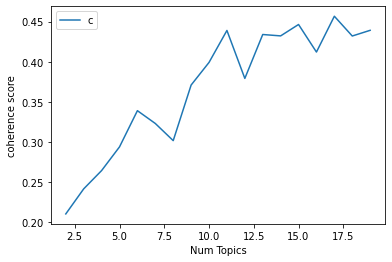

In [21]:
# Show graph

import matplotlib.pyplot as plt

limit=20; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_scores)
plt.xlabel("Num Topics")
plt.ylabel("coherence score")
plt.legend(("coherence score"), loc='best')
plt.show()

In [22]:
end here

SyntaxError: invalid syntax (<ipython-input-22-9bcc9ab561c7>, line 1)

### Final Model

In [11]:
num_topics = 17

lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10)

In [12]:
# Save the LDA model

from gensim.test.utils import datapath

lda_model_saved_file = datapath("sg_circuit_lda_model_17")
lda_model.save(lda_model_saved_file)

In [24]:
score = CoherenceModel(model=lda_model, texts=data_words_trigrams, dictionary=id2word, coherence='c_v')
score.get_coherence()

0.4406625683922607

In [25]:
import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis
import os

# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('./lda_model/sg_circuit_lda_vis_tuned_'+str(num_topics))

# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, './lda_vis/sg_circuit_lda_vis_tuned_'+ str(num_topics) +'.html')

LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.150350  0.188316       1        1  11.169549
7      0.119631  0.079128       2        1   7.815443
2     -0.007954  0.055248       3        1   7.033778
1     -0.157518 -0.091393       4        1   7.020160
10     0.012812 -0.010321       5        1   6.638819
4     -0.074202  0.004639       6        1   6.267367
3      0.069278  0.084467       7        1   6.060115
0      0.070272  0.015724       8        1   5.846040
16    -0.037763  0.016087       9        1   5.503106
11     0.056126 -0.045596      10        1   5.385952
14     0.058706  0.009850      11        1   5.021195
5      0.007667 -0.035569      12        1   4.877007
12     0.023550 -0.035335      13        1   4.703128
8     -0.014511 -0.009890      14        1   4.652107
15    -0.109693 -0.098365      15        1   4.500588
13     0.061868 -0.031665      16        1   3.856905
6      0.072081 -0.095324      17        1   3.648741, topic_info=                Term        Freq       Total Category  logprob  loglift
100        singapore  380.000000  380.000000  Default  30.0000  30.0000
14               new  107.000000  107.000000  Default  29.0000  29.0000
39              case  119.000000  119.000000  Default  28.0000  28.0000
149  circuit_breaker   63.000000   63.000000  Default  27.0000  27.0000
374           spread   47.000000   47.000000  Default  26.0000  26.0000
..               ...         ...         ...      ...      ...      ...
52           patient    4.792773   36.214097  Topic17  -5.1541   1.2884
157             next    4.175434   25.539575  Topic17  -5.2920   1.4998
21               amp    4.386163   79.313533  Topic17  -5.2427   0.4158
162             feel    3.674623   23.535382  Topic17  -5.4197   1.4537
274             time    3.907200  126.489318  Topic17  -5.3584  -0.1665

[1036 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
5445      7  0.804692          abc
3545     17  0.784298       access
2136     13  0.884787     accident
420       4  0.115884       across
420       6  0.115884       across
...     ...       ...          ...
1184      9  0.635391         york
2904     16  0.481929      youthsg
5628      1  0.865683        yummy
1452      7  0.935115         zero
4810     14  0.615550  zoommeeting

[2476 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 8, 3, 2, 11, 5, 4, 1, 17, 12, 15, 6, 13, 9, 16, 14, 7])

**Added Sentiment Analysis**

In [12]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

In [13]:
def determine_sentiment(score):
    if score < 0:
        return "Negative"
    elif score > 0:
        return "Positive"
    else:
        return "Neutral"

In [14]:
df["renderedContent"] = df['renderedContent'].apply(lambda tweet:str(tweet))
sentiment_scores = df['rawContent'].apply(sid.polarity_scores)
sentiment_scores

0       {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
1       {'neg': 0.0, 'neu': 0.674, 'pos': 0.326, 'comp...
2       {'neg': 0.0, 'neu': 0.584, 'pos': 0.416, 'comp...
3       {'neg': 0.0, 'neu': 0.847, 'pos': 0.153, 'comp...
4       {'neg': 0.165, 'neu': 0.688, 'pos': 0.147, 'co...
                              ...                        
1799    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
1800    {'neg': 0.0, 'neu': 0.667, 'pos': 0.333, 'comp...
1801    {'neg': 0.233, 'neu': 0.548, 'pos': 0.219, 'co...
1802    {'neg': 0.233, 'neu': 0.548, 'pos': 0.219, 'co...
1803    {'neg': 0.0, 'neu': 0.323, 'pos': 0.677, 'comp...
Name: rawContent, Length: 1804, dtype: object

In [15]:
# Load the saved model

from gensim.test.utils import datapath
lda_model_saved_file = datapath("sg_circuit_lda_model_17")
lda_model = gensim.models.ldamodel.LdaModel.load(lda_model_saved_file)

In [16]:
topics, num_topics = [], 17

for i in range(len(corpus)):
    top_topics = (
        lda_model.get_document_topics(corpus[i],
                                      minimum_probability=0.0))
    topic_vec = [top_topics[i][1] for i in range(num_topics)]
    topics.append(topic_vec.index(max(topic_vec))+1)
    
topics

[6,
 9,
 2,
 5,
 17,
 10,
 2,
 1,
 17,
 8,
 5,
 15,
 8,
 9,
 1,
 14,
 7,
 15,
 12,
 4,
 5,
 17,
 2,
 13,
 17,
 14,
 14,
 7,
 10,
 1,
 8,
 17,
 17,
 2,
 5,
 11,
 6,
 17,
 11,
 15,
 15,
 15,
 8,
 12,
 8,
 6,
 12,
 5,
 11,
 12,
 4,
 9,
 17,
 11,
 9,
 9,
 15,
 16,
 6,
 11,
 9,
 11,
 11,
 13,
 17,
 17,
 15,
 15,
 2,
 15,
 15,
 16,
 13,
 2,
 5,
 15,
 1,
 1,
 17,
 10,
 1,
 17,
 7,
 15,
 13,
 11,
 8,
 9,
 1,
 14,
 15,
 3,
 3,
 15,
 1,
 10,
 8,
 1,
 8,
 12,
 5,
 1,
 14,
 17,
 13,
 14,
 2,
 4,
 8,
 2,
 2,
 11,
 16,
 9,
 11,
 6,
 7,
 14,
 1,
 4,
 14,
 14,
 7,
 6,
 13,
 17,
 8,
 16,
 15,
 12,
 8,
 3,
 5,
 8,
 12,
 9,
 9,
 3,
 8,
 3,
 11,
 17,
 11,
 12,
 9,
 13,
 12,
 5,
 13,
 9,
 4,
 6,
 3,
 11,
 8,
 16,
 16,
 5,
 9,
 15,
 12,
 5,
 5,
 2,
 12,
 13,
 14,
 10,
 9,
 11,
 17,
 15,
 16,
 15,
 12,
 14,
 15,
 1,
 5,
 14,
 4,
 4,
 7,
 7,
 4,
 11,
 8,
 16,
 15,
 17,
 9,
 15,
 12,
 9,
 12,
 5,
 11,
 10,
 12,
 15,
 1,
 1,
 10,
 3,
 17,
 8,
 6,
 7,
 8,
 14,
 7,
 15,
 3,
 17,
 4,
 1,
 17,
 2,
 17,
 10,
 13,
 1

In [17]:
df["Topic"] = topics
df.head()

,url,date,rawContent,renderedContent,id,user,replyCount,retweetCount,likeCount,quoteCount,...,inReplyToUser,mentionedUsers,coordinates,place,hashtags,cashtags,card,viewCount,vibe,Topic
0,https://twitter.com/yihyng/status/126723739088...,2020-05-31 23:31:52+00:00,call call day,call call day,1267237390881402881,https://twitter.com/yihyng,0,0,1,0,...,NaN,NaN,"Coordinates(longitude=103.817832999913, latitu...","Place(id='5f1f473ed6455f55', fullName='North-E...",['covid_19'],NaN,NaN,NaN,NaN,6
1,https://twitter.com/JuiceTales/status/12672317...,2020-05-31 23:09:36+00:00,enter new phase one period healthy body grab n...,enter new phase one period healthy body grab n...,1267231786632790016,https://twitter.com/JuiceTales,0,0,0,0,...,NaN,NaN,"Coordinates(longitude=103.90126705, latitude=1...","Place(id='58a4c3a0d54e1400', fullName='Central...",NaN,NaN,NaN,NaN,NaN,9
2,https://twitter.com/sitimariamah1/status/12672...,2020-05-31 22:45:29+00:00,every new month brings new hope new dream new ...,every new month brings new hope new dream new ...,1267225719047950344,https://twitter.com/sitimariamah1,0,0,1,0,...,NaN,NaN,"Coordinates(longitude=103.93690062, latitude=1...","Place(id='6635b2fcebd13c64', fullName='East Re...",NaN,NaN,NaN,NaN,NaN,2
3,https://twitter.com/SajidTweetsBD/status/12671...,2020-05-31 15:23:06+00:00,meanwhile new zealand nine day new case pati...,meanwhile new zealand nine day new case pati...,1267114389150134272,https://twitter.com/SajidTweetsBD,0,0,0,0,...,NaN,NaN,"Coordinates(longitude=103.696411999967, latitu...","Place(id='14d9532bd696d8cb', fullName='North R...",NaN,NaN,NaN,NaN,NaN,5
4,https://twitter.com/audreytan/status/126710979...,2020-05-31 15:04:52+00:00,pandemic unlocked new thing never thought woul...,pandemic unlocked new thing never thought woul...,1267109798010478593,https://twitter.com/audreytan,0,0,1,0,...,NaN,NaN,"Coordinates(longitude=103.856, latitude=1.29306)","Place(id='58a4c3a0d54e1400', fullName='Central...",['Covid'],NaN,NaN,NaN,NaN,17


In [18]:
sentiments = sentiment_scores.apply(lambda x: x["compound"])
sentiment_label = sentiments.apply(determine_sentiment)
df["Sentiment"] = sentiment_label
df.head()

,url,date,rawContent,renderedContent,id,user,replyCount,retweetCount,likeCount,quoteCount,...,mentionedUsers,coordinates,place,hashtags,cashtags,card,viewCount,vibe,Topic,Sentiment
0,https://twitter.com/yihyng/status/126723739088...,2020-05-31 23:31:52+00:00,call call day,call call day,1267237390881402881,https://twitter.com/yihyng,0,0,1,0,...,NaN,"Coordinates(longitude=103.817832999913, latitu...","Place(id='5f1f473ed6455f55', fullName='North-E...",['covid_19'],NaN,NaN,NaN,NaN,6,Neutral
1,https://twitter.com/JuiceTales/status/12672317...,2020-05-31 23:09:36+00:00,enter new phase one period healthy body grab n...,enter new phase one period healthy body grab n...,1267231786632790016,https://twitter.com/JuiceTales,0,0,0,0,...,NaN,"Coordinates(longitude=103.90126705, latitude=1...","Place(id='58a4c3a0d54e1400', fullName='Central...",NaN,NaN,NaN,NaN,NaN,9,Positive
2,https://twitter.com/sitimariamah1/status/12672...,2020-05-31 22:45:29+00:00,every new month brings new hope new dream new ...,every new month brings new hope new dream new ...,1267225719047950344,https://twitter.com/sitimariamah1,0,0,1,0,...,NaN,"Coordinates(longitude=103.93690062, latitude=1...","Place(id='6635b2fcebd13c64', fullName='East Re...",NaN,NaN,NaN,NaN,NaN,2,Positive
3,https://twitter.com/SajidTweetsBD/status/12671...,2020-05-31 15:23:06+00:00,meanwhile new zealand nine day new case pati...,meanwhile new zealand nine day new case pati...,1267114389150134272,https://twitter.com/SajidTweetsBD,0,0,0,0,...,NaN,"Coordinates(longitude=103.696411999967, latitu...","Place(id='14d9532bd696d8cb', fullName='North R...",NaN,NaN,NaN,NaN,NaN,5,Positive
4,https://twitter.com/audreytan/status/126710979...,2020-05-31 15:04:52+00:00,pandemic unlocked new thing never thought woul...,pandemic unlocked new thing never thought woul...,1267109798010478593,https://twitter.com/audreytan,0,0,1,0,...,NaN,"Coordinates(longitude=103.856, latitude=1.29306)","Place(id='58a4c3a0d54e1400', fullName='Central...",['Covid'],NaN,NaN,NaN,NaN,17,Negative


In [19]:
for content in df[(df["Topic"] == 15) & (df["Sentiment"] == "Positive")].renderedContent:
    print(content)

circuitbreakingorange day cool cool evening right homecooked mala pot dinner stayhome stayathome singapore circuitbreakersg homecooking home
today singapore people recovered active patient sgunited singaporetogether
today singapore people recovered active patient sgunited singaporetogether
zakriadaughter aluinurliyana close si hahaha tgu  settle haha
circuit breaker singapore enhanced measure morning exercise today wednesday stay safe vigilant always choa chu kang park
circuitbreakingorange day homemade sourdough banmian noodle kimchi stew tummy warming lunch sourdoughdiscard kimchistew stayathome stayhome singapore
internationalmuseumday research essay look latest digital turn within museum sector prompted would love hear thought good vector reading worth reading topic 
fascinating story bhutan saved one american odyssey bhutan
know cake searched recipe  india people jolted routine simple pleasure like baking cooking fill void jump bandwagon beetroot pasta wfhfoodseries quarantinefood

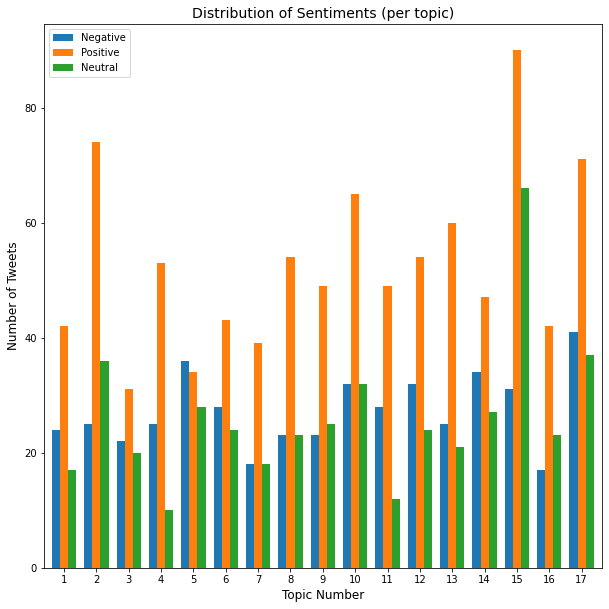

In [20]:
import matplotlib.pyplot as plt

topics = range(1, num_topics+1)
columns = ["Negative", "Positive", "Neutral"]
data = []

for i in range(num_topics):
    curr_topic = df[df["Topic"] == i+1]
    negative, positive, neutral = len(curr_topic[curr_topic["Sentiment"] == "Negative"]), len(curr_topic[curr_topic["Sentiment"] == "Positive"]), len(curr_topic[curr_topic["Sentiment"] == "Neutral"]) 
    data.append([negative, positive, neutral])

topic_sentiment_df = pd.DataFrame(data, columns=columns, index=topics)
topic_sentiment_df.plot(kind="bar", figsize=(10, 10), width=0.75)
plt.title("Distribution of Sentiments (per topic)", fontsize=14)
plt.xlabel("Topic Number", fontsize=12)
plt.ylabel("Number of Tweets", fontsize=12)
plt.gca().xaxis.set_tick_params(rotation=0)
plt.show()

## GSDMM

In [21]:
from gsdmm import MovieGroupProcess

gsdmm = MovieGroupProcess(K=17, alpha=0.1, beta=0.3, n_iters=15)

In [22]:
# vocab = set(word for doc in texts for word in doc)
n_terms = len(id2word)

doc_topic_labels = gsdmm.fit(texts, n_terms)
# doc_topic_labels

In stage 0: transferred 1510 clusters with 17 clusters populated
In stage 1: transferred 941 clusters with 17 clusters populated
In stage 2: transferred 670 clusters with 17 clusters populated
In stage 3: transferred 510 clusters with 17 clusters populated
In stage 4: transferred 465 clusters with 17 clusters populated
In stage 5: transferred 455 clusters with 17 clusters populated
In stage 6: transferred 413 clusters with 17 clusters populated
In stage 7: transferred 398 clusters with 17 clusters populated
In stage 8: transferred 370 clusters with 17 clusters populated
In stage 9: transferred 389 clusters with 17 clusters populated
In stage 10: transferred 355 clusters with 17 clusters populated
In stage 11: transferred 337 clusters with 17 clusters populated
In stage 12: transferred 341 clusters with 17 clusters populated
In stage 13: transferred 343 clusters with 17 clusters populated
In stage 14: transferred 354 clusters with 17 clusters populated


In [23]:
doc_count = np.array(gsdmm.cluster_doc_count)
print('Number of documents per topic :', doc_count)

# Topics sorted by the number of document they are allocated to
top_index = doc_count.argsort()[-15:][::-1]
print('Most important clusters (by number of docs inside):', top_index)

Number of documents per topic : [ 35  19  16  16  17 297  25 512 430   8 205  14  41  52  72  31  14]
Most important clusters (by number of docs inside): [ 7  8  5 10 14 13 12  0 15  6  1  4  3  2 11]


In [24]:
def top_words(cluster_word_distribution, top_cluster, values):
    for cluster in top_cluster:
        sort_dicts = sorted(gsdmm.cluster_word_distribution[cluster].items(), key=lambda k: k[1], reverse=True)[:values]
        print('Cluster %s : %s'%(cluster,sort_dicts))
        print('-'*120)

In [25]:
# Show the top 10 words in term frequency for each cluster 

top_words(gsdmm.cluster_word_distribution, top_index, 10)

Cluster 7 : [('case', 108), ('singapore', 104), ('new', 82), ('world', 52), ('day', 45), ('people', 43), ('need', 38), ('death', 38), ('patient', 37), ('via', 31)]
------------------------------------------------------------------------------------------------------------------------
Cluster 8 : [('time', 72), ('go', 60), ('singapore', 51), ('like', 43), ('home', 40), ('due', 35), ('want', 35), ('one', 34), ('day', 32), ('year', 32)]
------------------------------------------------------------------------------------------------------------------------
Cluster 5 : [('singapore', 103), ('may', 45), ('home', 36), ('amp', 34), ('stay', 34), ('safe', 32), ('time', 30), ('good', 21), ('measure', 21), ('india', 18)]
------------------------------------------------------------------------------------------------------------------------
Cluster 10 : [('singapore', 131), ('stayhome', 72), ('day', 67), ('circuitbreaker', 49), ('stayathome', 46), ('home', 41), ('staysafe', 29), ('lockdown', 23), 

In [26]:
df["GSDMM_Topic"] = doc_topic_labels
df.head()

,url,date,rawContent,renderedContent,id,user,replyCount,retweetCount,likeCount,quoteCount,...,coordinates,place,hashtags,cashtags,card,viewCount,vibe,Topic,Sentiment,GSDMM_Topic
0,https://twitter.com/yihyng/status/126723739088...,2020-05-31 23:31:52+00:00,call call day,call call day,1267237390881402881,https://twitter.com/yihyng,0,0,1,0,...,"Coordinates(longitude=103.817832999913, latitu...","Place(id='5f1f473ed6455f55', fullName='North-E...",['covid_19'],NaN,NaN,NaN,NaN,6,Neutral,7
1,https://twitter.com/JuiceTales/status/12672317...,2020-05-31 23:09:36+00:00,enter new phase one period healthy body grab n...,enter new phase one period healthy body grab n...,1267231786632790016,https://twitter.com/JuiceTales,0,0,0,0,...,"Coordinates(longitude=103.90126705, latitude=1...","Place(id='58a4c3a0d54e1400', fullName='Central...",NaN,NaN,NaN,NaN,NaN,9,Positive,12
2,https://twitter.com/sitimariamah1/status/12672...,2020-05-31 22:45:29+00:00,every new month brings new hope new dream new ...,every new month brings new hope new dream new ...,1267225719047950344,https://twitter.com/sitimariamah1,0,0,1,0,...,"Coordinates(longitude=103.93690062, latitude=1...","Place(id='6635b2fcebd13c64', fullName='East Re...",NaN,NaN,NaN,NaN,NaN,2,Positive,7
3,https://twitter.com/SajidTweetsBD/status/12671...,2020-05-31 15:23:06+00:00,meanwhile new zealand nine day new case pati...,meanwhile new zealand nine day new case pati...,1267114389150134272,https://twitter.com/SajidTweetsBD,0,0,0,0,...,"Coordinates(longitude=103.696411999967, latitu...","Place(id='14d9532bd696d8cb', fullName='North R...",NaN,NaN,NaN,NaN,NaN,5,Positive,7
4,https://twitter.com/audreytan/status/126710979...,2020-05-31 15:04:52+00:00,pandemic unlocked new thing never thought woul...,pandemic unlocked new thing never thought woul...,1267109798010478593,https://twitter.com/audreytan,0,0,1,0,...,"Coordinates(longitude=103.856, latitude=1.29306)","Place(id='58a4c3a0d54e1400', fullName='Central...",['Covid'],NaN,NaN,NaN,NaN,17,Negative,7


In [27]:
# Topic distribution

df.GSDMM_Topic.value_counts(dropna=False)

7     512
8     430
5     297
10    205
14     72
13     52
12     41
0      35
15     31
6      25
1      19
4      17
3      16
2      16
16     14
11     14
9       8
Name: GSDMM_Topic, dtype: int64

In [28]:
sort_dicts = dict(sorted(gsdmm.cluster_word_distribution[4].items(), key=lambda k: k[1], reverse=True))
# sort_dicts

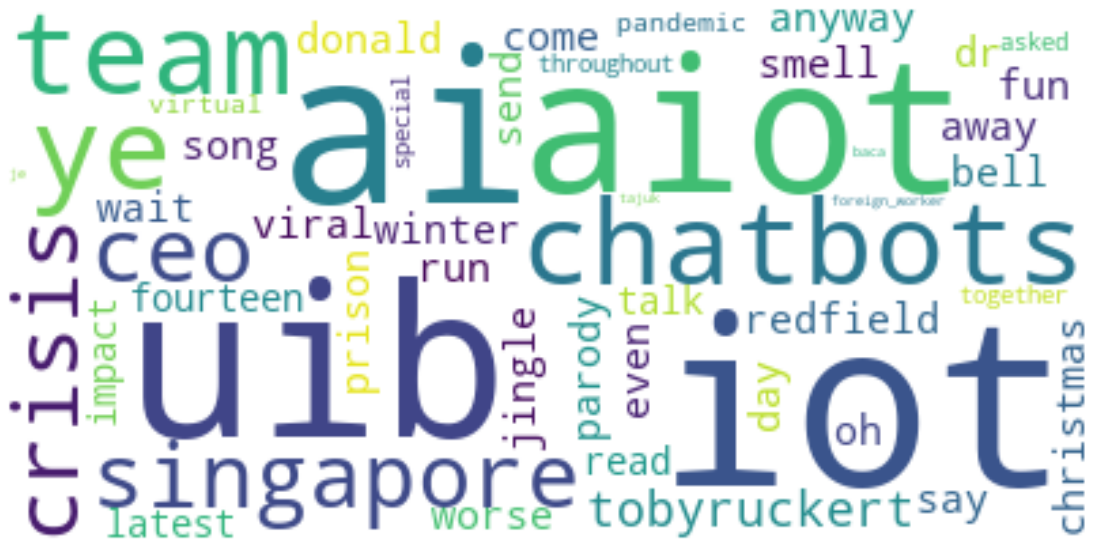

In [29]:
# Word cloud for Topic 5 (can change topic number accordingly)

wordcloud = WordCloud(background_color="white", max_words=50).generate_from_frequencies(sort_dicts)
fig, ax = plt.subplots(figsize=[20,10])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [30]:
def get_topics_lists(model, top_clusters, n_words):
    '''
    Gets lists of words in topics as a list of lists.
    
    model: gsdmm instance
    top_clusters:  numpy array containing indices of top_clusters
    n_words: top n number of words to include
    
    '''
    # create empty list to contain topics
    topics = []
    
    # iterate over top n clusters
    for cluster in top_clusters:
        #create sorted dictionary of word distributions
        sorted_dict = sorted(model.cluster_word_distribution[cluster].items(), key=lambda k: k[1], reverse=True)[:n_words]
         
        #create empty list to contain words
        topic = []
        
        #iterate over top n words in topic
        for k,v in sorted_dict:
            #append words to topic list
            topic.append(k)
            
        #append topics to topics list    
        topics.append(topic)
    
    return topics

In [31]:
# Check coherence score 

from gensim.models import CoherenceModel

topics = get_topics_lists(gsdmm, top_index, 10)

cm_gsdmm = CoherenceModel(topics=topics, 
                          dictionary=id2word, 
                          corpus=corpus, 
                          texts=texts, 
                          coherence='c_v')

cm_gsdmm.get_coherence()

0.4705357472474054

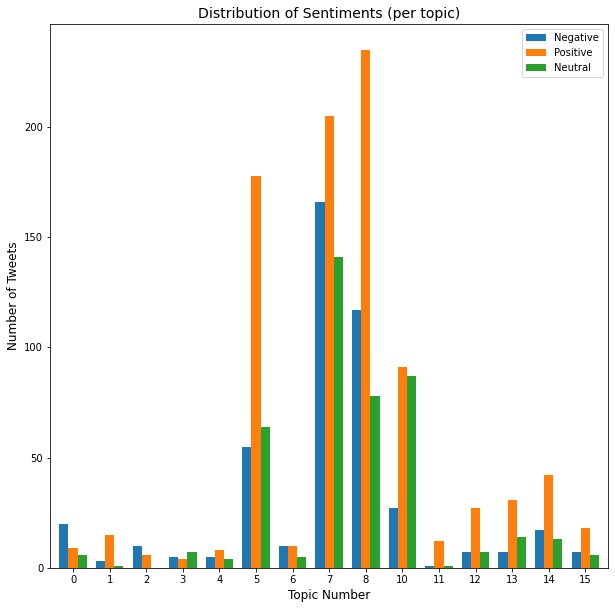

In [32]:
import matplotlib.pyplot as plt

top_index.sort()
columns = ["Negative", "Positive", "Neutral"]
data = []

for topic in top_index:
    curr_topic = df[df["GSDMM_Topic"] == topic]
    negative, positive, neutral = len(curr_topic[curr_topic["Sentiment"] == "Negative"]), len(curr_topic[curr_topic["Sentiment"] == "Positive"]), len(curr_topic[curr_topic["Sentiment"] == "Neutral"]) 
    data.append([negative, positive, neutral])

topic_sentiment_df = pd.DataFrame(data, columns=columns, index=top_index)
topic_sentiment_df.plot(kind="bar", figsize=(10, 10), width=0.75)
plt.title("Distribution of Sentiments (per topic)", fontsize=14)
plt.xlabel("Topic Number", fontsize=12)
plt.ylabel("Number of Tweets", fontsize=12)
plt.gca().xaxis.set_tick_params(rotation=0)
plt.show()

**Label topics**

In [33]:
import yake

kw_extractor = yake.KeywordExtractor(top=10, stopwords=stopwords)

**LDA**

In [34]:
topic_keyphrases = dict()

for i in range(num_topics):
    tweets = " ".join(df[df["Topic"] == i+1].renderedContent)
    topic_keyphrases[i+1] = [kp[0] for kp in kw_extractor.extract_keywords(tweets)]

In [35]:
keyphrase_column_names = [f"Keyphrase {i}" for i in range(1, 11)]
topic_keyphrases_df = pd.DataFrame.from_dict(topic_keyphrases, orient="index", columns=keyphrase_column_names)
topic_keyphrases_df

,Keyphrase 1,Keyphrase 2,Keyphrase 3,Keyphrase 4,Keyphrase 5,Keyphrase 6,Keyphrase 7,Keyphrase 8,Keyphrase 9,Keyphrase 10
1,stayhealthy wearmask socialdistancing,wearmask socialdistancing fastingmonth,socialdistancing fastingmonth covering,ramadan fast short,trekssl tip top,fastingmonth covering western,fast short ride,tip top condition,staysafe stayhealthy wearmask,old trekssl tip
2,circuit breaker measure,singapore circuit breaker,enhanced circuit breaker,lifeofrosse singaporeinsiders outbreak,breaker measure stem,new infection singapore,tuesday enhanced circuit,whole new world,soon rcssingapore sgunited,circuit breaker singapore
3,causing global health,government implemented breaker,implemented lockdown protect,faith easter testing,easter testing faith,emergency country implemented,global health emergency,keeping faith easter,country implemented lockdown,disease causing global
4,mexico paying wall,paying wall want,american crossing border,want american crossing,wall want american,news mexico paying,effort support local,savefnbsg especially restaurant,especially restaurant cafe,local business savefnbsg
5,death total death,today death total,case total case,case today death,new case total,new death total,hour today case,today case total,total case today,total case new
6,week pregnant lady,pregnant lady working,doctor suggestion must,suggestion must back,must back india,back india week,visakhapatnam week pregnant,india week flight,week flight doctor,flight doctor recommended
7,suction safe evacuation,safe evacuation pneumoperitoneum,evacuation pneumoperitoneum laparoscopy,action prohibiting citizen,prohibiting citizen travelling,citizen travelling foreigner,travelling foreigner entering,prevent spreading dah,spreading dah banyak,dah banyak kes
8,circuit breaker measure,circuit breaker period,affected circuit breaker,breaker period mti,circuit breaker shall,stay home stay,continue operating june,healthy must fight,period mti approved,clean safe healthy
9,immunity grab juice,grab juice cleanse,virus immunity grab,juice cleanse program,stay healthy promo,fight virus immunity,cleanse program stay,program stay healthy,healthy promo set,system fight virus
10,bellow stay safe,stay safe healthy,hotel hotelbatam batamhotel,healthy fight hotel,fight hotel hotelbatam,hotel please book,link bellow stay,safe healthy fight,click link bellow,hotelbatam batamhotel batam


**GSDMM**

In [36]:
cluster_keyphrases = dict()

for cluster in top_index:
    tweets = " ".join(df[df["GSDMM_Topic"] == cluster].renderedContent)
    cluster_keyphrases[cluster] = [kp[0] for kp in kw_extractor.extract_keywords(tweets)]

In [37]:
keyphrase_column_names = [f"Keyphrase {i}" for i in range(1, 11)]
cluster_keyphrases_df = pd.DataFrame.from_dict(cluster_keyphrases, orient="index", columns=keyphrase_column_names)
cluster_keyphrases_df

,Keyphrase 1,Keyphrase 2,Keyphrase 3,Keyphrase 4,Keyphrase 5,Keyphrase 6,Keyphrase 7,Keyphrase 8,Keyphrase 9,Keyphrase 10
0,death total death,today death total,case total case,hour today case,case today death,recover total recover,circuit breaker period,breaker period mti,period mti approved,mti approved continue
1,realize much circuitbreakersg,much circuitbreakersg sporemoh,forbes easterweekend goodfriday,easterweekend goodfriday supporting,heart postpone wedding,novel suppose wedding,suppose wedding turned,via forbes easterweekend,vital via chathamhouse,via chathamhouse joycehakmeh
2,suffering health fitness,health fitness financial,fitness financial really,flight travel back,travel back also,charge expensive foreigner,expensive foreigner woman,woman totally suffering,totally suffering health,financial really need
3,brunei cambodia myanmar,vietnam brunei cambodia,cambodia myanmar lao,myanmar lao asean,asean update apr,apr malaysia philippine,singapore vietnam brunei,philippine indonesia thailand,malaysia philippine indonesia,thailand singapore vietnam
4,redfield say even,say even worse,even worse winter,worse winter wait,winter wait parody,wait parody christmas,parody christmas song,christmas song jingle,song jingle bell,jingle bell smell
5,circuit breaker measure,stay home stay,home stay safe,may allah protect,time may allah,safe stay safe,health everyone may,safe stay home,may ramadan bring,everyone may blessing
6,many act kindness,act kindness heartwarming,kindness heartwarming story,heartwarming story singaporean,got beauty beast,beauty beast whole,wrong movie movementrestrictionorder,movie movementrestrictionorder movementcontrol...,movementrestrictionorder movementcontrolorder mro,movementcontrolorder mro mco
7,foreign worker dormitory,new case singapore,record new case,report new case,case infection singapore,singapore new case,new case death,singapore foreign worker,case new cluster,worker dormitory singapore
8,circuit breaker measure,amid circuit breaker,day circuit breaker,due circuit breaker,need best ccb,everything need best,circuit breaker shall,best ccb community,circuit breaker check,ccb community circuitbreaker
10,stayathome stayhome singapore,singapore circuitbreakingorange day,stayhome singapore circuitbreakersg,singapore circuitbreakersg home,stayhome stayathome singapore,jurong west singapore,west singapore circuitbreakingorange,day day singapore,stayhome singapore home,stayhome staysafe singapore
